# GAN Image Generation

In this notebook, we explore how Generative Adversarial Networks (GANs) generate images. We will use a pretrained GAN model (BigGAN) to generate images from random noise. 

A Generative Adversarial Network (GAN) consists of two networks, a generator and a discriminator whose purpose, respectively, is to map random noise to samples and discriminate between the real and generated samples. When applied to images, as in this experiment, the networks are usually Convolutional Neural Networks (CNNs). 

## Summary

In this experiment we use the [pytorch-pretrained-BigGAN](https://github.com/huggingface/pytorch-pretrained-BigGAN?tab=readme-ov-file#doc) and in particular, the 256x256 resolution model, to generate images. Three sets of images are generated, each with different values set for the latent vector input into the model. The seed for random noise generation remains the same so that we can isolate the effect of different truncation values on image generation.

The generator network takes the latent noise vector and the class vector as input. It processes these through a series of learned transformations to shape the random noise into a realistic image that aligns with the specified class. Because this is a pretrained model, these learned transformations are already optimized to create images.

Image set 1/3
Set 1:


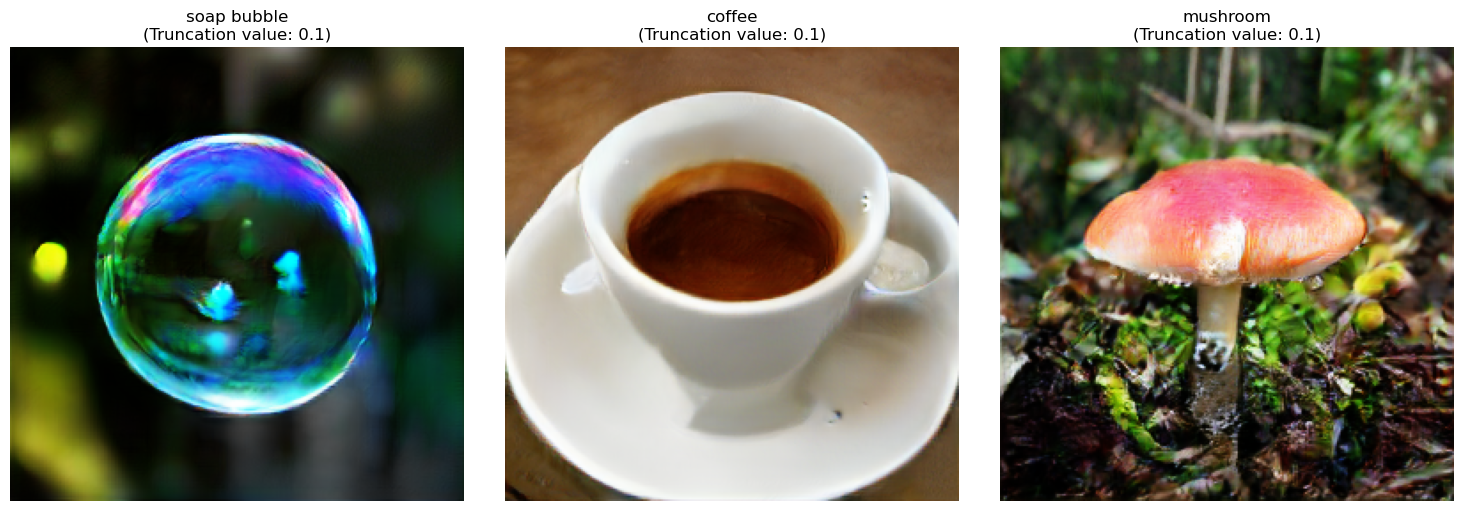

Image set 2/3
Set 2:


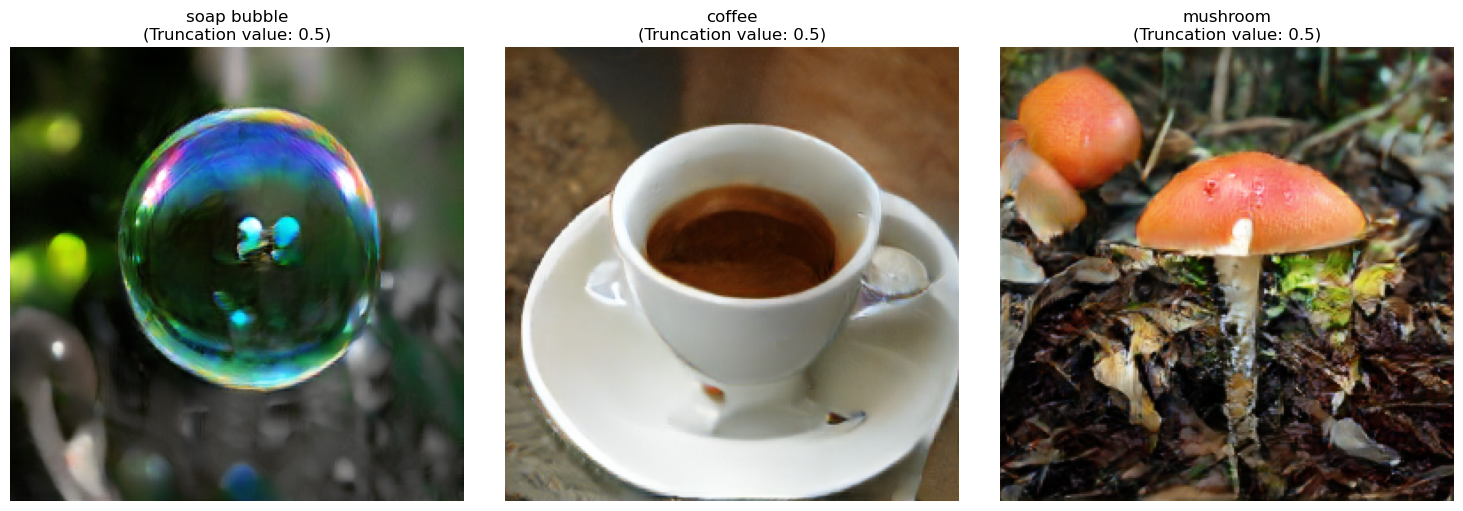

Image set 3/3
Set 3:


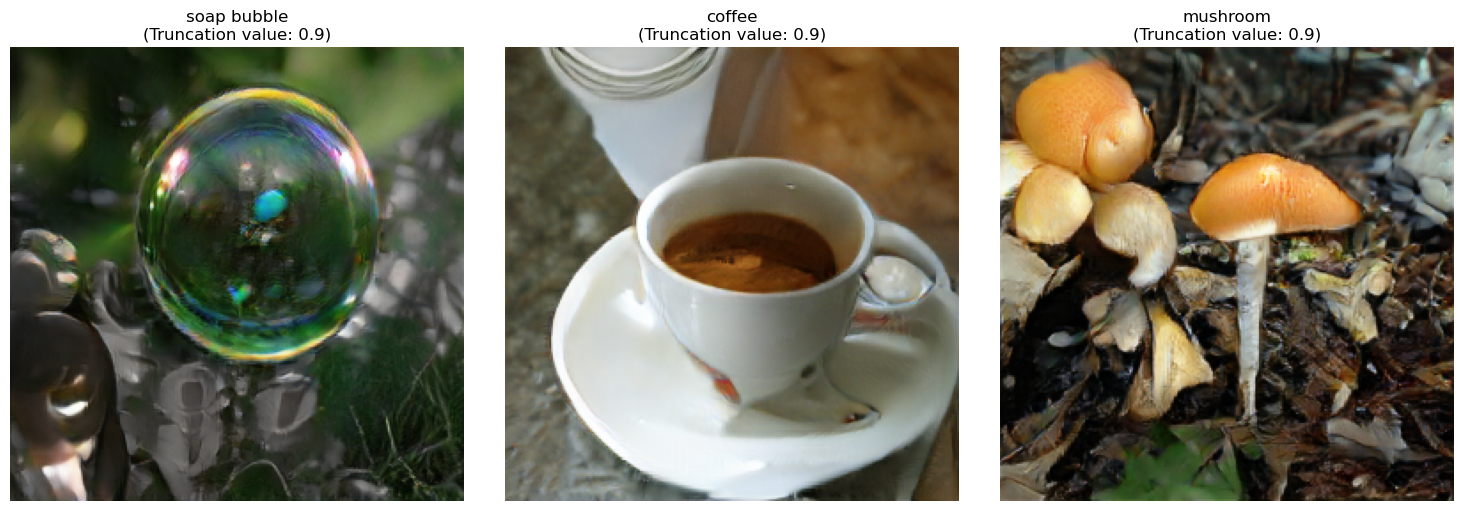

In [1]:
import torch
import random
from pytorch_pretrained_biggan import (BigGAN, one_hot_from_names, truncated_noise_sample,
                                       save_as_images, display_in_terminal)
import matplotlib.pyplot as plt

model = BigGAN.from_pretrained('biggan-deep-256')

# Experiment parameters
truncation = 0.1
class_names = ['soap bubble', 'coffee', 'mushroom']
batch_size = len(class_names)
num_noise_sets = 3

# Prepare class vector
class_vector_numpy = one_hot_from_names(class_names, batch_size)
class_vector_tensor = torch.from_numpy(class_vector_numpy)

for i in range(num_noise_sets):
    print(f"Image set {i+1}/{num_noise_sets}")

    if i == 1:
        truncation = 0.5
    elif i == 2:
        truncation = 0.9
    
    # Set a seed for noise vector
    seed = 56
    noise_vector_numpy = truncated_noise_sample(truncation=truncation, batch_size=batch_size, seed=seed)
    noise_vector_tensor = torch.from_numpy(noise_vector_numpy)

    with torch.no_grad():
        output = model(noise_vector_tensor, class_vector_tensor, truncation)

    output = output.to('cpu')

    # Display Images Horizontally in Jupyter Notebook using Matplotlib
    fig, axes = plt.subplots(1, batch_size, figsize=(15, 5))

    # Display the images
    print(f"Set {i+1}:")
    for j in range(output.size(0)):
        img_tensor = output[j]
        img_tensor_normalized = (img_tensor + 1) / 2
        img_tensor_normalized = img_tensor_normalized.clamp(0, 1) # Ensure that values are in [0, 1]

        # Permute dimensions from (Channels, Height, Width) to (Height, Width, Channels) for imshow
        img_display = img_tensor_normalized.permute(1, 2, 0).numpy()

        axes[j].imshow(img_display)
        axes[j].set_title(f"{class_names[j]}\n(Truncation value: {truncation})")
        axes[j].axis('off')

    plt.tight_layout() # Adjusts subplot params for a tight layout
    plt.show()

## Observations

We can see from the images that there is a clear difference in all three sets of images despite all of the images being generated from the same random noise sample. The difference being the truncation values for each set of images as shown in the labels. We can see that as the truncation value increases the images become more and more distorted. 

This effect is described in the paper [Large Scale GAN Training for High Fidelity Natural Image Synthesis](https://openreview.net/pdf?id=B1xsqj09Fm) as a tradeoff between variety and fidelity. As the truncation value approaches 0 the generated samples approch the mode of the generator's output distribution. This is clearly seen in the images above with the images with a low truncation value (0.1) appearing to be of much higher quality than those generated with truncation values of 0.5 and 0.9. This increase in fidelity comes at the cost of variety however, and image generation will be much more deterministic.

## Reflection

Now that you have generated images, write a brief report reflecting on your observations:

1. How did the generated images change when you modified the latent vector?
With truncation values approaching zero, the fidelity of the images is high, closely resembling the mode of the output distribution of the generator. As the truncation values increase, more variety is added to the images, reducing fidelity but generating more unique images. 

2. What patterns did you notice in the generated images? Were they realistic?
There is a level of realism in all of the images. However, as the truncation values increase we can see the images becoming more distorted.

3. How does the process of generating images from noise differ from traditional image generation methods?
Traditional image generation methods required more manual input from a person and were far more limited in the types of images that could be produced. The process of adversarial training with the model learning the statistical patterns of real data allows for the generation of more complex, diverse, and realistic images than traditional methods. 

4. What challenges or limitations did you observe with the GAN model?
While impressive, and a big step forward from traditional methods, a GAN only allows us to generate images from classes that the model was trained on. There is no mechanism for generalization and creation of images that the model has never seen before. I think that this is likely the largest drawback of using this method of image generation. 